# Get dotplot data

For each clone, get:

- V gene (identical for all clone members)
- CDR3 length (identical for all clone members)
- V-region mutation level, median across unique VDJ sequences in the clone (unweighted by read counts)
- Total read count, summed across all unique VDJ sequences in the clone

In [1]:
import dask
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import genetools
import seaborn as sns
from dask.distributed import Client

sns.set_style("dark")
import os
import time
from malid import config, helpers

In [2]:
client = Client(
    scheduler_port=config.dask_scheduler_port,
    dashboard_address=config.dask_dashboard_address,
    processes=True,
    n_workers=config.dask_n_workers,
    threads_per_worker=8,
    memory_limit="auto",  # TOTAL_MEMORY * min(1, nthreads / total_nthreads)
    worker_dashboard_address=":0",  # start worker dashboards on random ports
    local_directory="/tmp",  # https://github.com/dask/distributed/issues/3559#issuecomment-597321459
)

display(client)
# for debugging: client.restart()

Client Scheduler: tcp://127.0.0.1:61084 Dashboard: http://127.0.0.1:61083/status,Cluster Workers: 7 Cores: 56 Memory: 502.55 GiB


In [3]:
helpers.get_all_specimen_info()

,participant_label,specimen_label,disease,disease_subtype,specimen_time_point,age,participant_description,study_name,is_peak,study_id,patient_id_within_study,sex,fname,survived_filters,in_training_set,past_exposure,disease.separate_past_exposures
0,BFI-0000234,M124-S014,Healthy/Background,Healthy/Background - HIV Negative,NaN,27.0,Location: USA,Boydlab,True,NaN,NaN,NaN,NaN,True,True,False,Healthy/Background
1,BFI-0000234,M132-S014,Healthy/Background,Healthy/Background - HIV Negative,NaN,27.0,Location: USA,Boydlab,True,NaN,NaN,NaN,NaN,False,False,False,Healthy/Background
2,BFI-0002850,M124-S042,Healthy/Background,Healthy/Background - HIV Negative,NaN,26.0,Location: USA,Boydlab,True,NaN,NaN,NaN,NaN,True,True,False,Healthy/Background
3,BFI-0002850,M132-S040,Healthy/Background,Healthy/Background - HIV Negative,NaN,26.0,Location: USA,Boydlab,True,NaN,NaN,NaN,NaN,False,False,False,Healthy/Background
4,BFI-0002851,M124-S041,Healthy/Background,Healthy/Background - HIV Negative,NaN,27.0,Location: USA,Boydlab,True,NaN,NaN,NaN,NaN,True,True,False,Healthy/Background
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,327059,327059_1,Healthy/Background,Healthy/Background - Briney,0 days,NaN,NaN,Briney,True,NaN,NaN,NaN,/users/maximz/code/boyd-immune-repertoire-clas...,False,False,False,Healthy/Background
1048,326797,326797_1,Healthy/Background,Healthy/Background - Briney,0 days,NaN,NaN,Briney,True,NaN,NaN,NaN,/users/maximz/code/boyd-immune-repertoire-clas...,False,False,False,Healthy/Background
1049,D103,D103_1,Healthy/Background,Healthy/Background - Briney,0 days,NaN,NaN,Briney,True,NaN,NaN,NaN,/users/maximz/code/boyd-immune-repertoire-clas...,False,False,False,Healthy/Background
1050,326780,326780_1,Healthy/Background,Healthy/Background - Briney,0 days,NaN,NaN,Briney,True,NaN,NaN,NaN,/users/maximz/code/boyd-immune-repertoire-clas...,False,False,False,Healthy/Background


In [5]:
desired_columns = [
    "extracted_isotype",
    "specimen_label",
    "participant_label",
    "v_gene",
    #     "disease",
    #     "disease_subtype",
    "igh_or_tcrb_clone_id",
    "v_mut",
    "num_reads",
    "cdr3_aa_sequence_trim_len",
]

In [4]:
# debug_filters = [
#     ("specimen_label", "==", helpers.get_all_specimen_info().iloc[0]["specimen_label"])
# ]

In [6]:
# Each partition is one specimen
df = dd.read_parquet(
    config.paths.sequences,
    columns=desired_columns,
    #     filters=debug_filters, # Re-enable to debug
    engine="pyarrow",
)

In [7]:
df

,extracted_isotype,specimen_label,participant_label,v_gene,igh_clone_id,v_mut,num_reads,cdr3_aa_sequence_trim_len
npartitions=949,,,,,,,,
,category[unknown],category[known],category[known],category[unknown],int64,float64,int64,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [8]:
grpcols = [
    "participant_label",
    "specimen_label",
    "extracted_isotype",
    "igh_or_tcrb_clone_id",
]

In [9]:
# colors
clone_v_mut_median = df.map_partitions(
    lambda part: part.groupby(grpcols, observed=True)["v_mut"]
    .apply(pd.Series.median)
    .rename("clone_v_mut_median")
)
clone_v_mut_median

Dask Series Structure:
npartitions=949
    float64
        ...
     ...   
        ...
        ...
Name: clone_v_mut_median, dtype: float64
Dask Name: lambda, 1898 tasks

In [10]:
# reads per clone
sizes = df.map_partitions(
    lambda part: part.groupby(grpcols, observed=True)["num_reads"]
    .sum()
    .rename("clone_size")
)
sizes

Dask Series Structure:
npartitions=949
    int64
      ...
    ...  
      ...
      ...
Name: clone_size, dtype: int64
Dask Name: lambda, 1898 tasks

In [11]:
vgene = df.map_partitions(
    lambda part: part.groupby(grpcols, observed=True)["v_gene"].first()
)
vgene

Dask Series Structure:
npartitions=949
    object
       ...
     ...  
       ...
       ...
Name: v_gene, dtype: object
Dask Name: lambda, 1898 tasks

In [12]:
cdr3len = df.map_partitions(
    lambda part: part.groupby(grpcols, observed=True)[
        "cdr3_aa_sequence_trim_len"
    ].first()
)
cdr3len

Dask Series Structure:
npartitions=949
    int64
      ...
    ...  
      ...
      ...
Name: cdr3_aa_sequence_trim_len, dtype: int64
Dask Name: lambda, 1898 tasks

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0703715 to fit


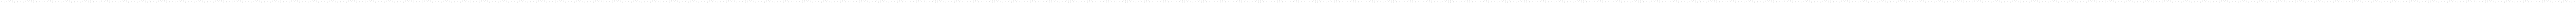

In [13]:
# dask.visualize(
#     clone_v_mut_median, sizes, vgene, cdr3len, filename="/tmp/dask.png"
# )  # filename=None has a bug

In [14]:
%%time
clone_v_mut_median_c, sizes_c, vgene_c, cdr3len_c = dask.compute(
    clone_v_mut_median, sizes, vgene, cdr3len
)

CPU times: user 30min 43s, sys: 2min 58s, total: 33min 41s
Wall time: 1h 41min 42s


In [15]:
clone_v_mut_median_c

specimen_label  extracted_isotype  igh_clone_id
M64-019         IGHG1              21              0.064655
                                   59              0.074236
                                   62              0.075221
                                   70              0.057940
                                   137             0.070796
                                                     ...   
M431-S250       IGHA2              13980           0.038961
                                   14065           0.084821
                                   14229           0.171946
                                   14510           0.127413
                                   14544           0.056769
Name: clone_v_mut_median, Length: 32978515, dtype: float64

In [16]:
sizes_c

specimen_label  extracted_isotype  igh_clone_id
M64-019         IGHG1              21               8
                                   59              11
                                   62               5
                                   70               2
                                   137             19
                                                   ..
M431-S250       IGHA2              13980            1
                                   14065            7
                                   14229            1
                                   14510            3
                                   14544            1
Name: clone_size, Length: 32978515, dtype: int64

In [17]:
vgene_c

specimen_label  extracted_isotype  igh_clone_id
M64-019         IGHG1              21              IGHV4-39
                                   59               IGHV3-9
                                   62               IGHV4-4
                                   70              IGHV3-15
                                   137              IGHV1-2
                                                     ...   
M431-S250       IGHA2              13980           IGHV3-30
                                   14065            IGHV1-8
                                   14229           IGHV1-18
                                   14510            IGHV2-5
                                   14544           IGHV3-23
Name: v_gene, Length: 32978515, dtype: object

In [18]:
cdr3len_c

specimen_label  extracted_isotype  igh_clone_id
M64-019         IGHG1              21              13
                                   59              15
                                   62              19
                                   70              10
                                   137             18
                                                   ..
M431-S250       IGHA2              13980           15
                                   14065           17
                                   14229           16
                                   14510           17
                                   14544           19
Name: cdr3_aa_sequence_trim_len, Length: 32978515, dtype: int64

In [19]:
merged_df = pd.concat([clone_v_mut_median_c, sizes_c, vgene_c, cdr3len_c], axis=1)
merged_df

clone_v_mut_median  clone_size  \
specimen_label extracted_isotype igh_clone_id                                   
M64-019        IGHG1             21                      0.064655           8   
                                 59                      0.074236          11   
                                 62                      0.075221           5   
                                 70                      0.057940           2   
                                 137                     0.070796          19   
...                                                           ...         ...   
M431-S250      IGHA2             13980                   0.038961           1   
                                 14065                   0.084821           7   
                                 14229                   0.171946           1   
                                 14510                   0.127413           3   
                                 14544                   0.056769           1   

                                                 v_gene  \
specimen_label extracted_isotype igh_clone_id             
M64-019        IGHG1             21            IGHV4-39   
                                 59             IGHV3-9   
                                 62             IGHV4-4   
                                 70            IGHV3-15   
                                 137            IGHV1-2   
...                                                 ...   
M431-S250      IGHA2             13980         IGHV3-30   
                                 14065          IGHV1-8   
                                 14229         IGHV1-18   
                                 14510          IGHV2-5   
                                 14544         IGHV3-23   

                                               cdr3_aa_sequence_trim_len  
specimen_label extracted_isotype igh_clone_id                             
M64-019        IGHG1             21                                   13  
                                 59                                   15  
                                 62                                   19  
                                 70                                   10  
                                 137                                  18  
...                                                                  ...  
M431-S250      IGHA2             13980                                15  
                                 14065                                17  
                                 14229                                16  
                                 14510                                17  
                                 14544                                19  

[32978515 rows x 4 columns]

In [22]:
merged_df = merged_df.reset_index()

,specimen_label,extracted_isotype,igh_clone_id,clone_v_mut_median,clone_size,v_gene,cdr3_aa_sequence_trim_len
0,M64-019,IGHG1,21,0.064655,8,IGHV4-39,13
1,M64-019,IGHG1,59,0.074236,11,IGHV3-9,15
2,M64-019,IGHG1,62,0.075221,5,IGHV4-4,19
3,M64-019,IGHG1,70,0.057940,2,IGHV3-15,10
4,M64-019,IGHG1,137,0.070796,19,IGHV1-2,18


In [26]:
merged_df

,specimen_label,extracted_isotype,igh_clone_id,clone_v_mut_median,clone_size,v_gene,cdr3_aa_sequence_trim_len,participant_label
0,M64-019,IGHG1,21,0.064655,8,IGHV4-39,13,BFI-0003068
1,M64-019,IGHG1,59,0.074236,11,IGHV3-9,15,BFI-0003068
2,M64-019,IGHG1,62,0.075221,5,IGHV4-4,19,BFI-0003068
3,M64-019,IGHG1,70,0.057940,2,IGHV3-15,10,BFI-0003068
4,M64-019,IGHG1,137,0.070796,19,IGHV1-2,18,BFI-0003068
...,...,...,...,...,...,...,...,...
32978510,M431-S250,IGHA2,13980,0.038961,1,IGHV3-30,15,BFI-0009645
32978511,M431-S250,IGHA2,14065,0.084821,7,IGHV1-8,17,BFI-0009645
32978512,M431-S250,IGHA2,14229,0.171946,1,IGHV1-18,16,BFI-0009645
32978513,M431-S250,IGHA2,14510,0.127413,3,IGHV2-5,17,BFI-0009645


In [36]:
merged_df["extracted_isotype"].value_counts()

IGHM     11925627
IGHD     11668846
gDNA      2892052
IGHG1     2210249
IGHA1     1862956
IGHA2      899067
IGHG2      828489
IGHG3      613529
IGHG4       50579
IGHE        27121
Name: extracted_isotype, dtype: int64

In [38]:
assert not merged_df["extracted_isotype"].isna().any()

In [41]:
# Export by participant label

In [42]:
config.paths.dotplots_input

PosixPath('/users/maximz/code/boyd-immune-repertoire-classification/data/combined_data.20220520_subset.dotplots/input')

In [43]:
for participant_label, participant_grp in merged_df[
    merged_df["extracted_isotype"] != "gDNA"
].groupby("participant_label", observed=True):
    fname_out = config.paths.dotplots_input / f"{participant_label}.tsv"  # .gz
    participant_grp.to_csv(fname_out, sep="\t", index=None)